Lasso, Ridge, Randomforest, ElasticNet, GradientBoostingRegressor, LGBM(dart), XGB(otherBoosting), AdaBoostRegressor

# 1. Import

In [1]:
# Basic Library
import os
import pandas as pd
import numpy as np
import pickle
from itertools import permutations, combinations
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb

In [2]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [3]:
train = pd.read_csv("../data/train_f2.csv")
test = pd.read_csv("../data/test_f2.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [4]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_hp = 3 # 파라미터 튜닝 seed 개수
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

In [5]:
pred_dict = {}
pred_test_dict = {}

In [6]:
train_ohe = train.copy()
test_ohe = test.copy()

train_ohe = pd.get_dummies(train_ohe)
test_ohe = pd.get_dummies(test_ohe)

train_x = train_ohe.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_ohe['Target']
test_x = test_ohe.copy()

print('One-Hot Encoding Completed')

One-Hot Encoding Completed


In [7]:
def xgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in [0, 42]:
        params_xgb = {
        "random_state": seed_hp,
        "verbose": None,
        "learning_rate": trial.suggest_uniform("learning_rate", 2e-3, 5e-2), # eta, default=0.3, range=[0,1]
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1e+2), # min_split_loss, default=0, range=[0,∞]
        "max_depth": trial.suggest_int("max_depth", 4, 10), # default=5, range=[0,∞]
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), #default=1
        "max_delta_step" : trial.suggest_int("max_delta_step", 0, 10), #default=0
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0), # default=1, range=(0,1]
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.2, 1.0), # default=1, range=(0,1]
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.2, 1.0), # default=1, range=(0,1]
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.2, 1.0), # default=1, range=(0,1]
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-1, 1e+1), # default=0, range=[0,∞]
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-1, 1e+1), # default=1, range=[0,∞]
        "max_bin": trial.suggest_int("max_bin", 100, 500),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values
            
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dvalid = xgb.DMatrix(x_val, label=y_val)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
                                                                                                # 진행상황 보고싶을때 None을 100으로
            xgbmodel = xgb.train(params_xgb, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)
            cv[val_idx] = xgbmodel.predict(dvalid)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [8]:
sampler = TPESampler(seed=basic_seed)
xgb_study = optuna.create_study(study_name="xgb_parameter_opt", direction="minimize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=num_trial)

xgb_best_hyperparams = xgb_study.best_trial.params
xgb_base_hyperparams = {"random_state": basic_seed}
xgb_best_hyperparams.update(xgb_base_hyperparams)

with open('../pickle/xgb_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(xgb_best_hyperparams, fw)
print("The best hyperparameters are:\n", xgb_best_hyperparams)

[I 2022-03-31 02:07:13,244] A new study created in memory with name: xgb_parameter_opt
[I 2022-03-31 02:50:48,711] Trial 0 finished with value: 1.531186663238696 and parameters: {'learning_rate': 0.019977925704673397, 'gamma': 63.512210106407046, 'max_depth': 9, 'min_child_weight': 6, 'max_delta_step': 1, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.24646688973455957, 'colsample_bylevel': 0.8929409166199482, 'colsample_bynode': 0.6808920093945671, 'reg_alpha': 2.607024758370768, 'reg_lambda': 0.10994335574766201, 'max_bin': 488}. Best is trial 0 with value: 1.531186663238696.
[I 2022-03-31 03:01:42,019] Trial 1 finished with value: 1.5418692683564692 and parameters: {'learning_rate': 0.04195724675842025, 'gamma': 0.07068974950624607, 'max_depth': 5, 'min_child_weight': 2, 'max_delta_step': 3, 'subsample': 0.5247564316322378, 'colsample_bytree': 0.5455560149136927, 'colsample_bylevel': 0.43298331215843355, 'colsample_bynode': 0.6894823157779035, 'reg_alpha': 0.190102453198703

XGBoostError: bad allocation

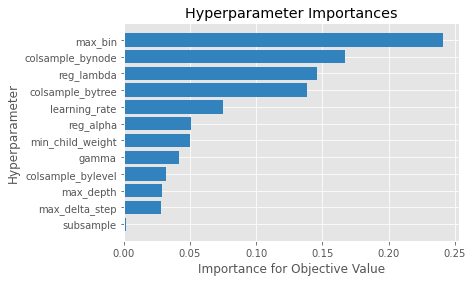

In [33]:
optuna.visualization.matplotlib.plot_param_importances(xgb_study);

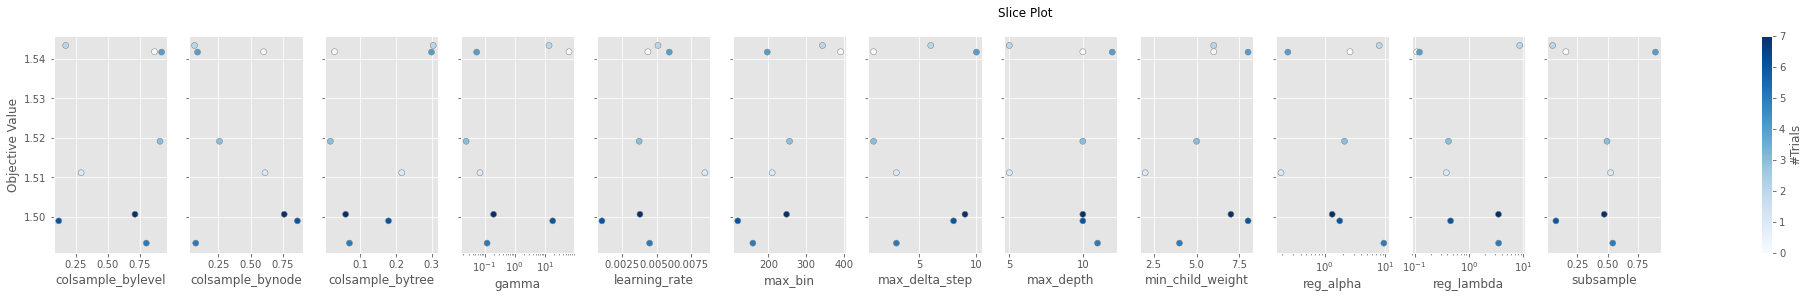

In [34]:
optuna.visualization.matplotlib.plot_slice(xgb_study);

In [8]:
with open('../pickle/xgb_best_hyperparams.pickle', 'rb') as fw:
    xgb_best_hyperparams = pickle.load(fw)

In [ ]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)
xgtest = xgb.DMatrix(test_x)
for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle = True) # CV 늘려가면서 하기
    cv=np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
        
        dtrain = xgb.DMatrix(x_train, label=y_train)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
        
                                                                                            # 진행상황 보고싶을때 None을 100으로
        xgbmodel = xgb.train(xgb_best_hyperparams, dtrain, 100000, watchlist, early_stopping_rounds=30, verbose_eval=None)

        cv[val_idx] = xgbmodel.predict(dvalid)
        pred_test += xgbmodel.predict(xgtest) / splits_tr # CV 바꾸면 이 숫자도 똑같이 바꿔야함
        
    pred_dict['xgb'+str(seed)] = cv
    pred_test_dict['xgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

# 3. Export

In [24]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), list(x[1])), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [25]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pickle/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [26]:
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)